This is my try to model COVID-19 pandemic in US using statistical learning methods.
 I will use recurrent neural networks to model confirmed-cases and deaths curves.

In [0]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [82]:
data = pd.read_csv("usa_county_wise.csv", sep=',')
data['Date'] = pd.to_datetime(data.Date)
data

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Deaths
0,16.0,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",2020-01-22,0,0
1,316.0,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,"Guam, US",2020-01-22,0,0
2,580.0,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",2020-01-22,0,0
3,630.0,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,"Puerto Rico, US",2020-01-22,0,0
4,850.0,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,"Virgin Islands, US",2020-01-22,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335878,84070016.0,US,USA,840,NaN,Central Utah,Utah,US,39.372319,-111.575868,"Central Utah, Utah, US",2020-05-03,24,0
335879,84070017.0,US,USA,840,NaN,Southeast Utah,Utah,US,38.996171,-110.701396,"Southeast Utah, Utah, US",2020-05-03,11,0
335880,84070018.0,US,USA,840,NaN,Southwest Utah,Utah,US,37.854472,-111.441876,"Southwest Utah, Utah, US",2020-05-03,111,2
335881,84070019.0,US,USA,840,NaN,TriCounty,Utah,US,40.124915,-109.517442,"TriCounty, Utah, US",2020-05-03,14,0


In [83]:
# dropping columns except some
cols = ['Date', 'Confirmed', 'Deaths']
data.drop(data.columns.difference(cols), 1, inplace=True)

# grouping by a date to summarise daily cases 
data_daily = data.groupby(by=['Date']).sum()
data_daily.describe()

,Confirmed,Deaths
count,1.030000e+02,103.000000
mean,2.327804e+05,12051.174757
std,3.571906e+05,20240.292837
min,1.000000e+00,0.000000
25%,1.300000e+01,0.000000
50%,2.147000e+03,50.000000
75%,4.128875e+05,17230.500000
max,1.158040e+06,67682.000000


Okay, one thing - the number of entries is pretty low. This might be challenging while teaching the network. It might be worth considering to reduce the timespan of the input data. 

Also ... the death toll is making me question the ethics of this project...

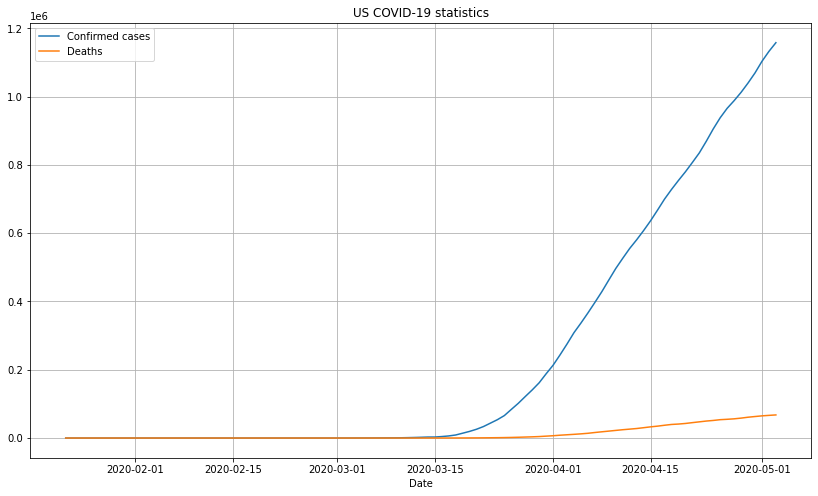

In [84]:
# visualize 
plt.figure(figsize=(14,8))
plt.title('US COVID-19 statistics')
plt.plot(data_daily['Confirmed'])
plt.plot(data_daily['Deaths'])
plt.grid()
plt.xlabel('Date')
plt.legend(['Confirmed cases', 'Deaths'])
plt.show()

As you can see, the curves seem to be exponential to some point and then linear. I'm curious if NN will predict, that both curves should be actually sigmoidal-ish

Let's split our problem into modeling cases and deaths

In [0]:
cases_data = data_daily.filter(['Confirmed'])
death_data = data_daily.filter(['Deaths'])

# convert into numpy array
cases_dataset = cases_data.values
death_dataset = death_data.values

# get the size of the training dataset
training_data_len = math.floor(len(data_daily)*0.85)

In [0]:
# scaling data for purposes of nn training
scaler = MinMaxScaler()
scaled_c_dataset = scaler.fit_transform(cases_dataset)
scaled_d_dataset = scaler.fit_transform(death_dataset)

train_c, train_d = scaled_c_dataset[:training_data_len], scaled_d_dataset[:training_data_len]
test_c, test_d = scaled_c_dataset[training_data_len:], scaled_d_dataset[training_data_len:]

In [0]:
# function creating input vectors and corresponding outputs
def create_in_out(data, x_size):
  x = []
  y = []
  for i in range(x_size, len(data)):
    x.append(data[i - x_size:i, 0])
    y.append(data[i, 0])
  return np.array(x), np.array(y)

In [0]:
span = 10
x_train_c, y_train_c = create_in_out(train_c, span)
x_train_d, y_train_d = create_in_out(train_d, span)

# reshaping data for LSTM
x_train_c = np.reshape(x_train_c, (x_train_c.shape[0], x_train_c.shape[1], 1))
x_train_d = np.reshape(x_train_d, (x_train_d.shape[0], x_train_d.shape[1], 1))

In [0]:
# let's quickly create validation data as well
x_test_c, y_test_c = create_in_out(test_c, span)
x_test_d, y_test_d = create_in_out(test_d, span)

# reshaping data for LSTM
x_test_c = np.reshape(x_test_c, (x_test_c.shape[0], x_test_c.shape[1], 1))
x_test_d = np.reshape(x_test_d, (x_test_d.shape[0], x_test_d.shape[1], 1))

Okay, now when I'm done with data processing it's time to build models

In [0]:
model_c = Sequential()
model_c.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(span,1)))
model_c.add(LSTM(100, return_sequences=True))
model_c.add(Dense(20, activation='relu'))
model_c.add(Dense(1, activation='softmax'))

model_c.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['accuracy']) 


In [95]:
# lets first take a look a cases
model_c.fit(x_train_c, y_train_c, epochs=3, validation_data=(x_test_c, y_test_c))


Epoch 1/3
3/3 [==============================] - 1s 184ms/step - loss: 0.8542 - accuracy: 0.0000e+00 - val_loss: 0.0058 - val_accuracy: 0.1667
Epoch 2/3
3/3 [==============================] - 0s 21ms/step - loss: 0.8392 - accuracy: 0.0000e+00 - val_loss: 0.0058 - val_accuracy: 0.1667
Epoch 3/3
3/3 [==============================] - 0s 21ms/step - loss: 0.8354 - accuracy: 0.0000e+00 - val_loss: 0.0058 - val_accuracy: 0.1667


Okay. The loss is horrible. Data augmentation time!